In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

In [31]:
df_anime = pd.read_csv("anime.csv")
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_rows, anime_cols = df_anime.shape

print(f"Jumlah baris data anime: {anime_rows}")
print(f"Jumlah kolom data anime: {anime_cols}")
print()

Jumlah baris data anime: 12294
Jumlah kolom data anime: 7



In [32]:
unique_anime_ids = df_anime['anime_id'].nunique()
print(f"Jumlah data anime ID: {unique_anime_ids}")

Jumlah data anime ID: 12294


In [33]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [34]:
df_anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


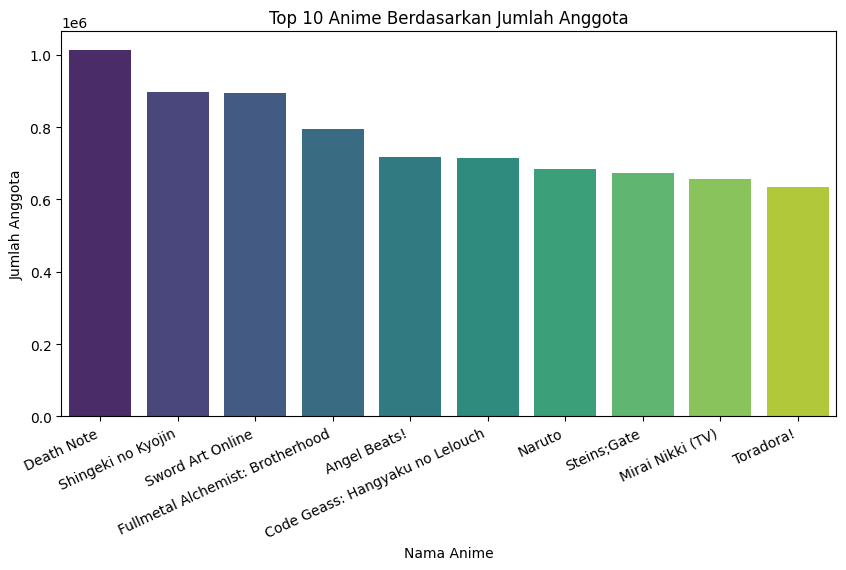

In [35]:
# Select top 10 anime based on the number of members
top_anime = df_anime.nlargest(10, 'members')

# Create a vertical bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x='name', y='members', data=top_anime, hue='name', palette='viridis', legend=False)
plt.title('Top 10 Anime Berdasarkan Jumlah Anggota')
plt.xlabel('Nama Anime')
plt.ylabel('Jumlah Anggota')
plt.xticks(rotation=25, ha='right')
plt.show()

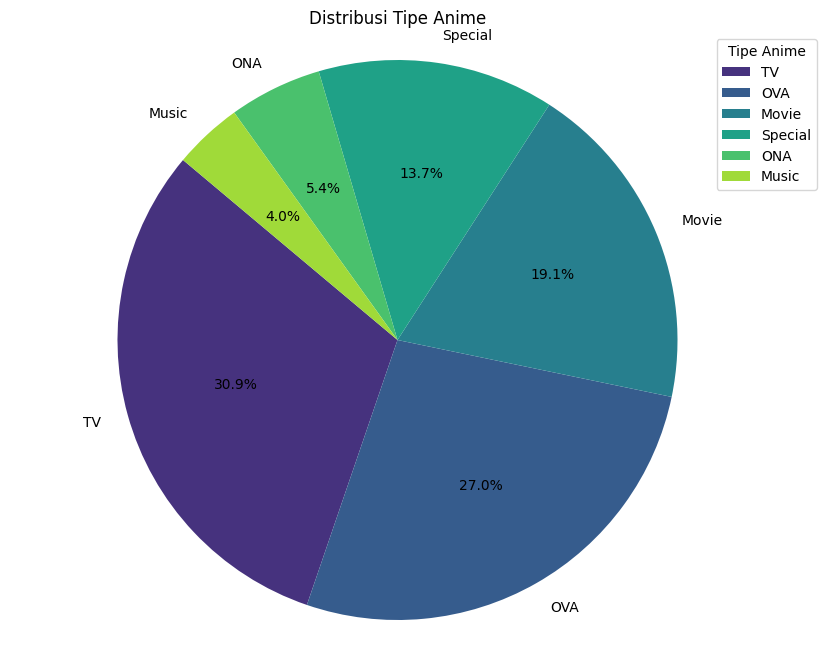

In [36]:
# Menghitung distribusi tipe anime
type_counts = df_anime['type'].value_counts()

# Membuat pie chart
plt.figure(figsize=(10, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(type_counts)))
plt.title('Distribusi Tipe Anime')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(type_counts.index, title="Tipe Anime", bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

In [37]:
# Menghitung distribusi genre anime
genre_counts = df_anime['genre'].str.split(',').explode().value_counts()

# Convert the genre_counts Series to a DataFrame
df_genre_counts = genre_counts.reset_index()
df_genre_counts.columns = ['Genre', 'Count']
df_genre_counts

,Genre,Count
0,Comedy,3193
1,Action,2845
2,Sci-Fi,1986
3,Fantasy,1815
4,Shounen,1663
...,...,...
77,Thriller,1
78,Police,1
79,Space,1
80,Super Power,1


In [38]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_anime[df_anime.duplicated()]

# Print the number of duplicate rows
print(f"Jumlah baris duplikat dalam dataframe anime: {duplicate_rows.shape[0]}")

Jumlah baris duplikat dalam dataframe anime: 0


In [39]:
# Hapus baris dengan nilai kosong pada kolom 'genre'
anime = df_anime.dropna(subset=['genre'])
anime.head(1)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630


In [40]:
# Membuat TF-IDF Vectorizer untuk mentransformasi kolom 'genre'
tfidf = TfidfVectorizer()
# Fit dan transform kolom 'genre'
tfidf_matrix = tfidf.fit_transform(anime['genre'])

In [41]:
# Mengubah matriks TF-IDF menjadi array
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29450574, 0.31749916, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25046406, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
# Inisialisasi NearestNeighbors model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

In [43]:
# Latih model NearestNeighbors
knn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [44]:
# Fungsi untuk mendapatkan rekomendasi berdasarkan model NearestNeighbors
def get_knn_recommendations(title, knn_model, anime, n=10):
    # Mendapatkan indeks anime yang sesuai dengan judul
    idx = anime[anime['name'] == title].index[0]

    # Mendapatkan vektor TF-IDF untuk anime yang diberikan
    tfidf_vector = tfidf_matrix[idx]

    # Menemukan n tetangga terdekat
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=n+1)

    # Mendapatkan indeks dari n anime yang paling mirip
    anime_indices = indices.flatten()[1:]

    # Mengembalikan n anime yang paling mirip
    return anime.iloc[anime_indices][['anime_id', 'name', 'genre', 'rating', 'members']]

In [45]:
# Meminta input judul anime dari user
judul_input = input("Masukkan judul anime: ")

# Memastikan judul anime yang diinput ada di dataset
if judul_input in anime['name'].tolist():
    # Mencetak judul anime input dan genrenya
    genre_input = anime[anime['name'] == judul_input]['genre'].values[0]
    print(f"Judul anime yang dimasukkan: {judul_input}")
    print(f"Genre dari anime tersebut: {genre_input}")

    # Mendapatkan rekomendasi untuk judul anime input menggunakan KNN
    rekomendasi_knn = get_knn_recommendations(judul_input, knn_model, anime, n=5)
    print("\nRekomendasi anime serupa:")
    display(rekomendasi_knn)
else:
    print(f"Judul '{judul_input}' tidak ditemukan dalam dataset.")

Masukkan judul anime: One Piece
Judul anime yang dimasukkan: One Piece
Genre dari anime tersebut: Action, Adventure, Comedy, Drama, Fantasy, Shounen, Super Power

Rekomendasi anime serupa:


,anime_id,name,genre,rating,members
896,31289,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",7.78,11922
231,19123,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.29,17247
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",8.58,504862
941,462,One Piece Movie 4: Dead End no Bouken,"Action, Adventure, Comedy, Fantasy, Shounen, S...",7.76,39946
2161,8171,One Piece Recap,"Action, Adventure, Comedy, Fantasy, Shounen, S...",7.34,10147


In [46]:
# Calculate the number of unique anime
num_anime = df_anime['anime_id'].nunique()

In [47]:
# Menggunakan df_anime asli untuk regresi, lalu membersihkannya
df_anime_reg = df_anime.dropna(subset=['rating', 'type', 'episodes', 'genre']).copy()

# Lakukan One-Hot Encoding untuk kolom 'type'
df_anime_reg = pd.get_dummies(df_anime_reg, columns=['type'], prefix='type')

# Pisahkan fitur dan target
X_reg = df_anime_reg.select_dtypes(include=np.number).drop(['members', 'anime_id'], axis=1)
y_reg = df_anime_reg['members']

In [48]:
# Penskalaan Fitur
scaler_X = MinMaxScaler()
X_reg_scaled = scaler_X.fit_transform(X_reg)

# Penskalaan Target
# Reshape y_reg menjadi array 2D karena scaler.fit_transform() mengharapkan input 2D
scaler_y = MinMaxScaler()
y_reg_scaled = scaler_y.fit_transform(y_reg.values.reshape(-1, 1)).flatten() # Flatten kembali ke 1D setelah scaling

In [49]:
# Split data untuk pelatihan dan pengujian menggunakan data yang sudah diskalakan
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg_scaled, test_size=0.2, random_state=42)

# Check the shapes and first few rows of scaled data
print("X_train_reg shape:", X_train_reg.shape)
print("y_train_reg shape:", y_train_reg.shape)
print("X_test_reg shape:", X_test_reg.shape)
print("y_test_reg shape:", y_test_reg.shape)

print("\nX_train_reg (scaled, first 2 rows):\n", X_train_reg[:2])
print("\ny_train_reg (scaled, first 2 rows):\n", y_train_reg[:2])

# Simpan min/max dari target asli untuk unscaling prediksi nanti
min_members_original = y_reg.min()
max_members_original = y_reg.max()


X_train_reg shape: (9613, 1)
y_train_reg shape: (9613,)
X_test_reg shape: (2404, 1)
y_test_reg shape: (2404,)

X_train_reg (scaled, first 2 rows):
 [[0.73229292]
 [0.44537815]]

y_train_reg (scaled, first 2 rows):
 [3.96131787e-02 7.00262845e-05]


In [50]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_regression_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    # Jika target sudah diskalakan ke 0-1, pakai sigmoid; jika belum, gunakan linear (no activation)
    outputs = Dense(1, activation='sigmoid')(x)  # Gunakan sigmoid jika target 0-1 setelah scaling
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Dapatkan bentuk input dari data pelatihan
input_shape = X_train_reg.shape[1]

# Bangun model regresi
model_reg = build_regression_model(input_shape)

# Compile model regresi
# Loss 'mean_squared_error' cocok untuk regresi
model_reg.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

# Tampilkan ringkasan model
model_reg.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Definisikan Early Stopping callback
early_stopping_reg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Latih model regresi
history_reg = model_reg.fit(
    x=X_train_reg,
    y=y_train_reg,
    batch_size=512,
    epochs=50,
    verbose=1,
    validation_data=(X_test_reg, y_test_reg),
    callbacks=[early_stopping_reg]
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2142 - mean_absolute_error: 0.4598 - val_loss: 0.1538 - val_mean_absolute_error: 0.3888
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1390 - mean_absolute_error: 0.3689 - val_loss: 0.0956 - val_mean_absolute_error: 0.3046
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0843 - mean_absolute_error: 0.2850 - val_loss: 0.0521 - val_mean_absolute_error: 0.2222
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0454 - mean_absolute_error: 0.2056 - val_loss: 0.0267 - val_mean_absolute_error: 0.1561
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - mean_absolute_error: 0.1454 - val_loss: 0.0148 - val_mean_absolute_error: 0.1127
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.1064 - val_loss: 0.0096 - val_mean_absolute_error: 0.0873
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0844 - val_loss: 0.00

In [52]:
# Simpan model KNN rekomendasi
joblib.dump(knn_model, 'knn_recommender_model.pkl')
print("Model KNN untuk sistem rekomendasi berhasil disimpan.")

Model KNN untuk sistem rekomendasi berhasil disimpan.


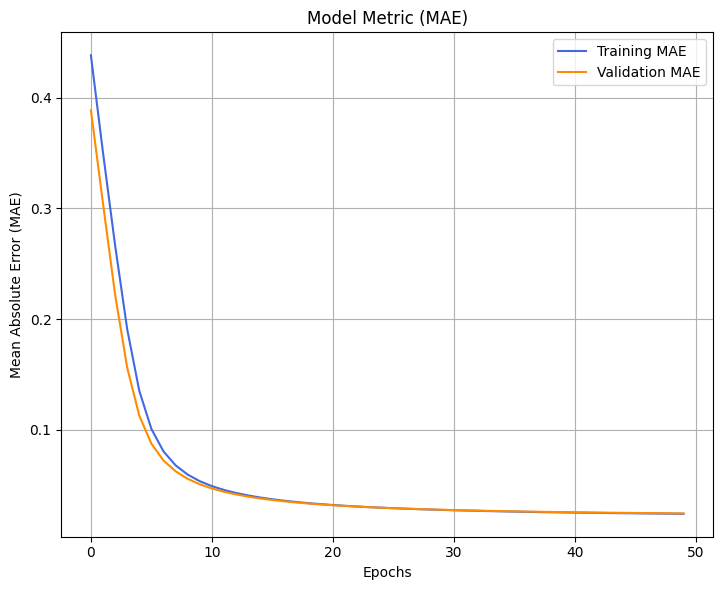

In [53]:
# Ambil metrik dari history
loss = history_reg.history['loss']                    # MSE - training
val_loss = history_reg.history['val_loss']            # MSE - validation
mae = history_reg.history['mean_absolute_error']      # MAE - training
val_mae = history_reg.history['val_mean_absolute_error']  # MAE - validation

epochs = range(len(loss))  # Jumlah epoch

# Buat plot side-by-side
plt.figure(figsize=(14, 6))

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, label='Training MAE', color='royalblue')
plt.plot(epochs, val_mae, label='Validation MAE', color='darkorange')
plt.title('Model Metric (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

      Rendah       0.81      0.83      0.82       794
      Tinggi       0.83      0.81      0.82       817

    accuracy                           0.82      1611
   macro avg       0.82      0.82      0.82      1611
weighted avg       0.82      0.82      0.82      1611



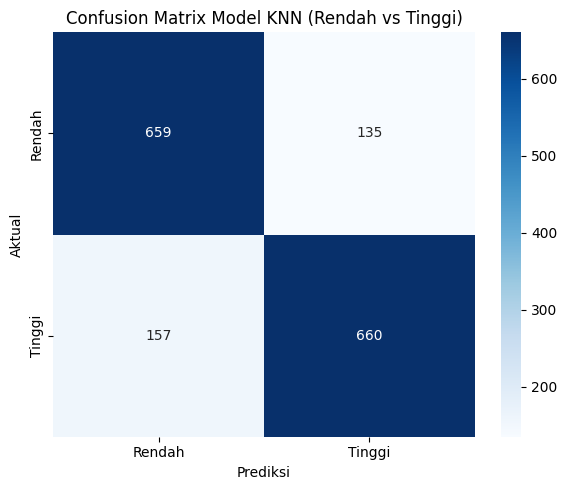

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Bersihkan dataset dan kategorikan popularitas
df_anime_cls = df_anime.dropna(subset=['members', 'rating', 'type', 'episodes', 'genre']).copy()
low_threshold = df_anime_cls['members'].quantile(0.33)
high_threshold = df_anime_cls['members'].quantile(0.66)

def categorize_popularity_binary(members):
    if members <= low_threshold:
        return 'Rendah'
    elif members > high_threshold:
        return 'Tinggi'
    else:
        return np.nan  # Buang kelas 'Sedang'

df_anime_cls['popularity_category'] = df_anime_cls['members'].apply(categorize_popularity_binary)
df_anime_cls = df_anime_cls.dropna(subset=['popularity_category'])  # Buang baris kelas 'Sedang'

# Encode target menjadi numerik
label_encoder = LabelEncoder()
df_anime_cls['popularity_category_encoded'] = label_encoder.fit_transform(df_anime_cls['popularity_category'])
df_anime_cls = pd.get_dummies(df_anime_cls, columns=['type'], prefix='type')

# Pilih fitur dan target
X_cls = df_anime_cls.select_dtypes(include=np.number).drop(['members', 'anime_id', 'popularity_category_encoded'], axis=1)
y_cls = df_anime_cls['popularity_category_encoded']

# Split data dengan stratify
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

# Latih model KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_cls, y_train_cls)

# Prediksi
y_pred_cls = knn.predict(X_test_cls)

# Confusion matrix dan classification report
cm = confusion_matrix(y_test_cls, y_pred_cls)
class_names = label_encoder.classes_

print(classification_report(y_test_cls, y_pred_cls, target_names=class_names))

# Visualisasi confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix Model KNN (Rendah vs Tinggi)')
plt.tight_layout()
plt.show()